# Annotate paintings
This notebook leverages an LLM to extract the described objects that appear in a painting and then ground them with Grounding DINO.

### 0. Import libraries and set the configuration

In [1]:
%load_ext autoreload
%autoreload 2

import time
from tqdm import tqdm

from config import *
from call_llm import *
from ground_objects import *
from compute_metrics import *
from judge_annotations import *
from annotate_paintings_utils import *

### 1. Import models and data

In [2]:
# get device type
device = get_device()

# load models
llm_client = get_llm_client()
judge_client = get_judge_llm_client()
grounding_processor, grounding_model = get_grounding_model(device)
sentence_similarity_model = get_sentence_similarity_model()

# load data
paintings_data, annotations, few_shot_examples, test_paintings = load_data()

# if an image is not included, it doesn't have annotations
ground_truth_bboxes, labels_to_ids = get_bbox_annotations()

### 2. Experiment with annotation prompts

In [ ]:
def extract_objects(
    llm_client, few_shot_examples, image, painting, total_token_count, total_token_count_judge
):
    feedback = None
    object_extraction_trials_no = 2
    unprocessed_painting_id = None
    painting_id_to_check = None
    painting_id_wo_objects = None

    while object_extraction_trials_no > 0:
        llm_output, token_count, prompt_parts, reponse_parts = generate(
            llm_client,
            few_shot_examples,
            image,
            painting["description"],
            None,
            f"{PROMPT_TYPE}_object_extraction",
            feedback,
        )
        total_token_count += token_count

        if llm_output is None:
            unprocessed_painting_id = painting["painting_id"]
            break

        llm_output = sort_and_clean_output(llm_output, painting)

        if len(llm_output) == 0:
            painting_id_wo_objects = painting["painting_id"]
            object_and_spans = None
            break

        object_and_spans = {"object_names": [], "descriptions_spans": []}

        for llm_output_ in llm_output:
            object_and_spans["object_names"].append(llm_output_.object_name)
            object_and_spans["descriptions_spans"].append(llm_output_.description_spans)

        if not JUDGE_OUTPUT:
            object_extraction_trials_no = 0
            break

        object_extraction_suggestions, _, token_count_judge = judge_objects_extractions(
            judge_client, image, painting["description"], object_and_spans
        )
        total_token_count_judge += token_count_judge
        object_extraction_trials_no -= 1

        if len(object_extraction_suggestions) != 0 and object_extraction_trials_no <= 0:
            painting_id_to_check = painting["painting_id"]
        elif len(object_extraction_suggestions) != 0:
            feedback = [prompt_parts, reponse_parts, object_extraction_suggestions]
        else:
            object_extraction_trials_no = 0

    return (
        llm_output,
        object_and_spans,
        painting_id_wo_objects,
        unprocessed_painting_id,
        painting_id_to_check,
        total_token_count,
        total_token_count_judge,
    )

In [8]:
def compose_object_description(
    llm_client,
    few_shot_examples,
    object_and_spans,
    object_description_metrics,
    painting_id,
    total_token_count,
    total_token_count_judge,
):
    feedback = None
    object_description_trials_no = 2
    unprocessed_painting_id = None
    painting_id_to_check = None

    while object_description_trials_no > 0:
        llm_output, token_count, prompt_parts, reponse_parts = generate(
            llm_client,
            few_shot_examples,
            None,
            None,
            object_and_spans,
            f"{PROMPT_TYPE}_create_description",
            feedback,
        )
        total_token_count += token_count

        if llm_output is None:
            unprocessed_painting_id = painting_id
            break

        if len(object_and_spans["object_names"]) != len(llm_output):
            print("The annotator didn't provide the number of expected descriptions.")
            unprocessed_painting_id = painting_id
            break

        if not JUDGE_OUTPUT:
            object_description_trials_no = 0
            break

        object_and_spans["objects_description"] = [
            annotation.object_description for annotation in llm_output
        ]
        object_description_suggestions, token_count_judge, inconsistent_scoring = judge_objects_descriptions(
            judge_client, object_and_spans, object_description_metrics
        )
        total_token_count_judge += token_count_judge
        object_description_trials_no -= 1

        if inconsistent_scoring:
            painting_id_to_check = painting_id
            object_description_trials_no = 0
        if len(object_description_suggestions) != 0 and object_description_trials_no <= 0:
            painting_id_to_check = painting_id
        elif len(object_description_suggestions) != 0:
            feedback = [prompt_parts, reponse_parts, object_description_suggestions]
        else:
            object_description_trials_no = 0

    return (
        llm_output,
        unprocessed_painting_id,
        painting_id_to_check,
        total_token_count,
        total_token_count_judge,
    )

  0%|          | 0/1 [00:00<?, ?it/s]

PAINTING DESCRIPTION
Writing to the sculptor Auguste Rodin after having been astonished by this painting in Paris in 1908, the poet Rainer Maria Rilke described how “splintered light tills the ground, turning it over, tearing into it and bringing up here and there pale green meadows behind the trees standing like insomniacs.” Regarded as El Greco’s greatest landscape, it portrays Toledo, the city where he lived and worked for most of his life. But it is an emotive rather than a documentary vision that not only imaginatively revises the skyline—most notably, the cathedral has been moved—but also distorts architecture and landscape such that they are fully in service of the kind of drama Rilke and other modernists appreciated in his work.
We know remarkably little about the circumstances around the creation of this masterpiece, El Greco's greatest surviving landscape. There is a possibility that it was still in the artist's studio when he died, for in the inventory of his possessions dra

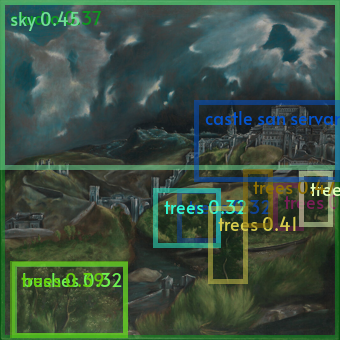

100%|██████████| 1/1 [01:00<00:00, 60.08s/it]

Micro F1 for extracting objects: 0.12
Micro F1 for extracting spans: 0
mAP@50: 0.0
mAP@50-95: 0.0
mAP per class: tensor([ 0.,  0.,  0., -1.])
classes: tensor([ 34,  36,  66, 112], dtype=torch.int32)


In [9]:
# object metrics
micro_f1_objects = None
tp_fp_fn_objects = [0, 0, 0]
all_predicted_objects = []
all_ground_truth_objects = []

# spans metrics
micro_f1_spans = None
tp_fp_fn_spans = [0, 0, 0]
span_similarity_metrics = {
    "cosine similarity": [],
    "Levenshtein distance": [],
    "delete percentage": [],
    "false positive percentage": [],
    "coverage percentage": [],
}
all_predicted_spans = []
all_ground_truth_spans = []

# object descriptions metrics
object_description_metrics = {
    "factual_accuracy": [],
    "coherence": [],
    "grounding_potential": [],
    "completeness": [],
}
all_predicted_object_descriptions = []

# grounding metrics
map_50 = None
map_50_95 = None
all_predicted_bboxes = []
all_ground_truth_bboxes = []

# other tracked info
total_token_count = 0
total_token_count_judge = 0
painting_ids = []
paintings_ids_tp_check = []
unprocessed_painting_ids = []
paintings_ids_wo_objects = []

for painting in tqdm(test_paintings[3:4]):
    image = load_image(painting["painting_id"])
    print(f"PAINTING DESCRIPTION\n{painting['description']}")
    
    # extract described objects
    (
        llm_output_objects,
        object_and_spans,
        painting_id_wo_objects,
        unprocessed_painting_id,
        painting_id_to_check,
        total_token_count,
        total_token_count_judge,
    ) = extract_objects(
        llm_client, few_shot_examples, image, painting, total_token_count, total_token_count_judge
    )

    if unprocessed_painting_id is not None:
        unprocessed_painting_ids.append(unprocessed_painting_id)
        print("UNPROCESSED PAINTING")
        continue

    if painting_id_wo_objects is not None:
        paintings_ids_wo_objects.append(painting_id_wo_objects)
        print("PAINTING WITHOUT OBJECTS")
        continue

    if painting_id_to_check is not None:
        paintings_ids_tp_check.append(painting_id_to_check)
        print("PAINTING HAS TO BE CHECKED")

    # create description per object
    (
        llm_output_descriptions,
        unprocessed_painting_id,
        painting_id_to_check,
        total_token_count,
        total_token_count_judge,
    ) = compose_object_description(
        llm_client,
        few_shot_examples,
        copy.deepcopy(object_and_spans),
        object_description_metrics,
        painting["painting_id"],
        total_token_count,
        total_token_count_judge,
    )

    if unprocessed_painting_id is not None:
        unprocessed_painting_ids.append(unprocessed_painting_id)
        print("UNPROCESSED PAINTING")
        continue

    if painting_id_to_check is not None:
        paintings_ids_tp_check.append(painting_id_to_check)
        print("PAINTING HAS TO BE CHECKED")

    # handle objects
    predicted_objects, ground_truth_objects = process_objects(
        llm_output_objects, painting, all_predicted_objects, all_ground_truth_objects
    )
    count_tp_fp_fn(predicted_objects, ground_truth_objects, tp_fp_fn_objects)

    # handle spans
    (
        predicted_spans_per_object,
        ground_truth_spans_per_object,
        predicted_spans,
        ground_truth_spans,
    ) = process_spans(llm_output_objects, painting)
    compute_spans_quality(
        ground_truth_spans_per_object,
        predicted_spans_per_object,
        span_similarity_metrics,
        sentence_similarity_model,
    )
    count_tp_fp_fn(predicted_spans, ground_truth_spans, tp_fp_fn_spans)
    all_predicted_spans.append(predicted_spans_per_object)
    all_ground_truth_spans.append(ground_truth_spans_per_object)

    # handle object description
    get_object_descriptions(llm_output_descriptions, all_predicted_object_descriptions)

    # ground objects
    labels_scores_boxes, grounding_results = detect_objects(
        image,
        predicted_objects,
        grounding_processor,
        grounding_model,
        device,
        object_threshold=0.3,
        text_threshold=0.3,
    )

    get_bounding_boxes(
        labels_scores_boxes,
        labels_to_ids,
        ground_truth_bboxes,
        painting["painting_id"],
        all_predicted_bboxes,
        all_ground_truth_bboxes,
        device,
    )

    # if this line has been reached, the full image processing is done
    painting_ids.append(painting["painting_id"])

# compute metrics across the entire dataset
micro_f1_objects = compute_micro_f1(tp_fp_fn_objects, "objects")

micro_f1_spans = compute_micro_f1(tp_fp_fn_spans, "spans")
for metric in span_similarity_metrics:
    span_similarity_metrics[metric] = np.array(span_similarity_metrics[metric]).mean()

for metric in object_description_metrics:
    object_description_metrics[metric] = np.array(object_description_metrics[metric]).mean()

map_50, map_50_95 = compute_mean_average_precision(
    all_predicted_bboxes, all_ground_truth_bboxes, device
)

In [11]:
# store results for the tested prompt
predictions = []

assert len(all_predicted_spans) == len(all_predicted_object_descriptions)

for index, painting_data in enumerate(all_predicted_spans):
    object_descriptions = all_predicted_object_descriptions[index]
    object_data = {}

    for object_index, (object, spans) in enumerate(painting_data.items()):
        object_data[object] = [spans, object_descriptions[object_index]]

    predictions.append(object_data)

results_values = list(zip(painting_ids, predictions, all_ground_truth_spans))

metrics = {
    "total_token_count": total_token_count,
    "total_token_count_judge": total_token_count_judge,
    "unprocessed_painting_ids": unprocessed_painting_ids,
    "paintings_ids_tp_check": paintings_ids_tp_check,
    "micro_f1_objects": micro_f1_objects,
    "micro_f1_spans": micro_f1_spans,
    "span_similarity_metrics": span_similarity_metrics,
    "object_description_metrics": object_description_metrics,
    "map_50": map_50,
    "map_50_95": map_50_95,
}

observations = "first trial with few-shot learning"
store_results(PROMPT_TYPE, observations, results_values, metrics)

### 3. Create object-descriptions for few-shot examples

In [ ]:
def get_ground_truth_objects_description():
    class Description(BaseModel):
        description: str

    system_prompt_text = """You are an art expert providing detailed descriptions of objects depicted in paintings. 
    You are given an object name and a set of descriptive text spans from the painting's museum label. 
    Your task is to create a single, coherent description paragraph that starts with the object name of the object based solely on the provided information. 
    You have to included all the provided details from the description spans.

    **Constraints:**
    Do not add any details about the object that are not explicitly mentioned in the provided description spans.
    Do not infer the object's material, purpose, or origin unless it is directly stated in the text.
    Focus on combining and rephrasing the given information, not on creating new information.
    Do not assume anything about the object's cultural significance or symbolism unless the provided spans mention it."""

    _, _, few_shot_examples, _ = load_data()

    for few_shot_example in few_shot_examples:
        print(few_shot_example["painting_id"])

        for index in range(len(few_shot_example["object_name"])):

            object_name = few_shot_example["object_name"][index]
            description_spans = "- " + "\n- ".join(few_shot_example["description_spans"][index])

            if len(description_spans) == 2:
                print(object_name)
                continue

            prompt_parts_text = f"""**Object Name:**\n{object_name}\n\n**Description Spans:**\n{description_spans}\n\n**Generated Description:**"""

            generate_content_config = types.GenerateContentConfig(
                temperature=0.0,
                response_mime_type="application/json",
                system_instruction=[
                    types.Part.from_text(text=system_prompt_text),
                ],
                response_schema=Description,
            )

            called = False

            while not called:
                try:
                    response = llm_client.models.generate_content(
                        model=GEMINI_MODEL,
                        contents=prompt_parts_text,
                        config=generate_content_config,
                    )
                    called = True
                except:
                    print("Try again...")
                    time.sleep(5)

            print("---")
            print(object_name)
            print(description_spans)
            print(response.parsed.description)